<a href="https://colab.research.google.com/github/Linda0319/Deepsolar/blob/main/deepsolar_Feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **上傳資料/DeepSolar套件**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
%matplotlib inline

In [ ]:
#匯入module .csv檔
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROUTE = '/content/drive/MyDrive/Colab Notebooks/deepsolar_tract.csv'
df = pd.read_csv(ROUTE,sep=',',header=0)

In [ ]:
# replace處理空白，將其轉為null
df.electricity_price_transportation = df.electricity_price_transportation.replace(r'\s', np.nan,regex=True)
df.electricity_price_transportation=df.electricity_price_transportation.astype(np.float64)
df.electricity_price_transportation

0         9.50
1         9.50
2         9.50
3         9.50
4         9.50
         ...  
72532    10.08
72533      NaN
72534      NaN
72535      NaN
72536     5.34
Name: electricity_price_transportation, Length: 72537, dtype: float64

In [ ]:
# nan 刪除
df_clean = df.dropna()
df_clean

,ID,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,education_less_than_high_school,education_master,education_population,education_professional_school,employed,gini_index,heating_fuel_coal_coke,heating_fuel_electricity,heating_fuel_fuel_oil_kerosene,heating_fuel_gas,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_other,heating_fuel_solar,land_area,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_count,race_asian,race_black_africa,race_indian_alaska,race_islander,race_other,race_two_more,race_white,state,total_area,...,occupancy_vacant_rate,occupancy_owner_rate,mortgage_with_rate,transportation_home_rate,transportation_car_alone_rate,transportation_walk_rate,transportation_carpool_rate,transportation_motorcycle_rate,transportation_bicycle_rate,transportation_public_rate,travel_time_less_than_10_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,health_insurance_none_rate,age_median,travel_time_average,voting_2016_dem_percentage,voting_2016_gop_percentage,voting_2016_dem_win,voting_2012_dem_percentage,voting_2012_gop_percentage,voting_2012_dem_win,number_of_years_of_education,diversity,number_of_solar_system_per_household,incentive_count_residential,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,1757,336,157,4548,26,3569,0.3490,200,448,98,1720,2527,10,51,0,147.73120,26999.0,6577,44.520050,85,1911,28,19,16,0,6,88,6420,mn,154.371900,...,0.137837,0.776868,0.627580,0.088343,0.795371,0.019193,0.086367,0.003387,0.002258,0.003669,0.130341,0.212693,0.213932,0.241176,0.088854,0.067802,0.249962,0.070330,43.9,29.0,0.323796,0.602874,False,0.429,0.550,False,13.232410,0.046960,0.000000,34,39,11,13,34,0,0,25,12,0,9.46
2,2,3.0,3.0,64.505776,27145011302,71496.886583,Stearns County,854,1459,31,1541,289,276,4480,30,3550,0.3926,69,440,45,2098,2698,29,17,0,37.44482,28021.0,6971,186.167300,134,1961,0,0,2,0,18,12,6939,mn,39.330500,...,0.072534,0.776212,0.640390,0.033475,0.841986,0.034894,0.076879,0.008794,0.000000,0.000000,0.236865,0.206927,0.262107,0.199296,0.042559,0.041385,0.255264,0.037171,39.6,21.0,0.323796,0.602874,False,0.429,0.550,False,13.647991,0.009150,0.001112,34,39,11,13,34,0,0,25,12,0,9.46
3,3,0.0,0.0,0.000000,27145011304,86840.152755,Stearns County,640,1116,68,1095,231,270,3456,36,3483,0.3949,188,442,61,1113,1833,13,16,0,75.21147,29275.0,6328,84.136100,87,1499,171,69,26,0,305,64,5693,mn,81.040710,...,0.176550,0.745283,0.637734,0.135988,0.677795,0.079020,0.086677,0.001225,0.001838,0.014395,0.190358,0.344913,0.251684,0.114498,0.060262,0.021624,0.185051,0.050727,30.9,21.0,0.323796,0.602874,False,0.429,0.550,False,13.858796,0.187334,0.000000,34,39,11,13,34,0,0,25,12,0,9.46
4,4,5.0,5.0,164.583303,27145011400,89135.315597,Stearns County,654,1314,15,982,163,170,3348,50,2887,0.4463,96,497,47,1202,1917,31,44,0,44.00151,32770.0,5264,119.632300,73,1473,34,91,0,0,0,122,5017,mn,44.600170,...,0.043413,0.678643,0.601471,0.042524,0.843848,0.016731,0.088184,0.000000,0.000000,0.002440,0.119767,0.344376,0.294503,0.098289,0.046960,0.065890,0.272710,0.023424,34.5,25.0,0.323796,0.602874,False,0.429,0.550,False,13.850956,0.090766,0.002087,34,39,11,13,34,0,0,25,12,0,9.46
5,5,0.0,0.0,0.000000,27145011500,62225.903614,Stearns County,522,1395,24,1894,442,142,4448,29,3270,0.3847,72,759,81,1695,2656,45,4,0,148.87050,25776.0,6531,43.870350,64,1718,0,83,8,0,156,29,6255,mn,151.885700,...,0.066432,0.628822,0.609838,0.057179,0.814168,0.055591,0.048920,0.001271,0.007942,0.007624,0.436321,0.260108,0.099057,0.067049,0.075135,0.042116,0.313149,0.098807,41.3,18.0,0.323796

In [ ]:
drop_columns=['county','state','voting_2016_dem_win','voting_2012_dem_win','ID','solar_panel_area_divided_by_area',
         'tile_count','tile_count_residential','tile_count_nonresidential','solar_system_count','total_panel_area',
         'fips','solar_panel_area_per_capita','solar_system_count_residential',
         'solar_system_count_nonresidential','number_of_solar_system_per_household','total_panel_area_nonresidential',
         'heating_fuel_solar_rate','heating_fuel_solar']
df_area = df_clean.drop(drop_columns,axis=1)
df_area.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45179 entries, 0 to 72536
Columns: 150 entries, average_household_income to avg_electricity_retail_rate
dtypes: float64(106), int64(44)
memory usage: 52.0 MB


In [ ]:
y_area = 'total_panel_area_residential'
area_desc = df_area[y_area].describe() 
area_desc

count    45179.000000
mean       546.550595
std       1509.026315
min          0.000000
25%          5.940687
50%         65.938532
75%        366.094661
max      40380.099851
Name: total_panel_area_residential, dtype: float64

In [ ]:
count=0
for i in df_area[y_area]:
  if i <= area_desc['25%']:
    count += 1
count

11295

In [ ]:
count=0
for i in df_area[y_area]:
  if i >= area_desc['75%']:
    count += 1
count

11295

In [ ]:
#22590筆，0,1各11295筆
df_area['Install_class'] = df_area[y_area].apply(lambda x: (0 if (x <= area_desc['25%']) else (1 if (x > area_desc['75%']) else np.nan)) )
df_area[df_area['Install_class'] == 1].Install_class
#df_area[df_area['Install_class'] == 0].Install_class
df_area

,average_household_income,education_bachelor,education_college,education_doctoral,education_high_school_graduate,education_less_than_high_school,education_master,education_population,education_professional_school,employed,gini_index,heating_fuel_coal_coke,heating_fuel_electricity,heating_fuel_fuel_oil_kerosene,heating_fuel_gas,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_other,land_area,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_count,race_asian,race_black_africa,race_indian_alaska,race_islander,race_other,race_two_more,race_white,total_area,unemployed,water_area,education_less_than_high_school_rate,education_high_school_graduate_rate,education_college_rate,education_bachelor_rate,education_master_rate,education_professional_school_rate,...,occupation_arts_rate,occupation_agriculture_rate,occupancy_vacant_rate,occupancy_owner_rate,mortgage_with_rate,transportation_home_rate,transportation_car_alone_rate,transportation_walk_rate,transportation_carpool_rate,transportation_motorcycle_rate,transportation_bicycle_rate,transportation_public_rate,travel_time_less_than_10_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,health_insurance_none_rate,age_median,travel_time_average,voting_2016_dem_percentage,voting_2016_gop_percentage,voting_2012_dem_percentage,voting_2012_gop_percentage,number_of_years_of_education,diversity,incentive_count_residential,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate,Install_class
0,70352.789869,569,1690,13,1757,336,157,4548,26,3569,0.3490,200,448,98,1720,2527,10,51,147.73120,26999.0,6577,44.520050,85,1911,28,19,16,0,6,88,6420,154.371900,136,6.640769,0.073879,0.386324,0.371592,0.125110,0.034521,0.005717,...,0.063323,0.059681,0.137837,0.776868,0.627580,0.088343,0.795371,0.019193,0.086367,0.003387,0.002258,0.003669,0.130341,0.212693,0.213932,0.241176,0.088854,0.067802,0.249962,0.070330,43.9,29.0,0.323796,0.602874,0.429,0.550,13.232410,0.046960,34,39,11,13,34,0,0,25,12,0,9.46,0.0
2,71496.886583,854,1459,31,1541,289,276,4480,30,3550,0.3926,69,440,45,2098,2698,29,17,37.44482,28021.0,6971,186.167300,134,1961,0,0,2,0,18,12,6939,39.330500,151,1.885683,0.064509,0.343973,0.325670,0.190625,0.061607,0.006696,...,0.048169,0.030704,0.072534,0.776212,0.640390,0.033475,0.841986,0.034894,0.076879,0.008794,0.000000,0.000000,0.236865,0.206927,0.262107,0.199296,0.042559,0.041385,0.255264,0.037171,39.6,21.0,0.323796,0.602874,0.429,0.550,13.647991,0.009150,34,39,11,13,34,0,0,25,12,0,9.46,NaN
3,86840.152755,640,1116,68,1095,231,270,3456,36,3483,0.3949,188,442,61,1113,1833,13,16,75.21147,29275.0,6328,84.136100,87,1499,171,69,26,0,305,64,5693,81.040710,186,5.829235,0.066840,0.316840,0.322917,0.185185,0.078125,0.010417,...,0.095607,0.035889,0.176550,0.745283,0.637734,0.135988,0.677795,0.079020,0.086677,0.001225,0.001838,0.014395,0.190358,0.344913,0.251684,0.114498,0.060262,0.021624,0.185051,0.050727,30.9,21.0,0.323796,0.602874,0.429,0.550,13.858796,0.187334,34,39,11,13,34,0,0,25,12,0,9.46,0.0
4,89135.315597,654,1314,15,982,163,170,3348,50,2887,0.4463,96,497,47,1202,1917,31,44,44.00151,32770.0,5264,119.632300,73,1473,34,91,0,0,0,122,5017,44.600170,154,0.598656,0.048686,0.293309,0.392473,0.195341,0.050777,0.014934,...,0.041912,0.029789,0.043413,0.678643,0.601471,0.042524,0.843848,0.016731,0.088184,0.000000,0.000000,0.002440,0.119767,0.344376,0.294503,0.098289,0.046960,0.065890,0.272710,0.023424,34.5,25.0,0.323796,0.602874,0.429,0.550,13.850956,0.090766,34,39,11,13,34,0,0,25,12,0,9.46,NaN
5,62225.903614,522,1395,24,1894,442,142,4448,29,3270,0.3847,72,759,81,1695,2656,45,4,148.87050,25776.0,6531,43.870350,64,1718,0,83,8,0,156,29,6255,151.885700,92,3.015256,0.099371,0.425809,0.313624,0.117356,0.031924,0.006520,...,0.

In [ ]:
df_tree = df_area.dropna()
df_x = df_tree.drop(['total_panel_area_residential','Install_class'],axis=1)
df_x

,average_household_income,education_bachelor,education_college,education_doctoral,education_high_school_graduate,education_less_than_high_school,education_master,education_population,education_professional_school,employed,gini_index,heating_fuel_coal_coke,heating_fuel_electricity,heating_fuel_fuel_oil_kerosene,heating_fuel_gas,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_other,land_area,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_count,race_asian,race_black_africa,race_indian_alaska,race_islander,race_other,race_two_more,race_white,total_area,unemployed,water_area,education_less_than_high_school_rate,education_high_school_graduate_rate,education_college_rate,education_bachelor_rate,education_master_rate,education_professional_school_rate,...,occupation_transportation_rate,occupation_arts_rate,occupation_agriculture_rate,occupancy_vacant_rate,occupancy_owner_rate,mortgage_with_rate,transportation_home_rate,transportation_car_alone_rate,transportation_walk_rate,transportation_carpool_rate,transportation_motorcycle_rate,transportation_bicycle_rate,transportation_public_rate,travel_time_less_than_10_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,health_insurance_none_rate,age_median,travel_time_average,voting_2016_dem_percentage,voting_2016_gop_percentage,voting_2012_dem_percentage,voting_2012_gop_percentage,number_of_years_of_education,diversity,incentive_count_residential,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,70352.789869,569,1690,13,1757,336,157,4548,26,3569,0.3490,200,448,98,1720,2527,10,51,147.73120,26999.0,6577,44.520050,85,1911,28,19,16,0,6,88,6420,154.371900,136,6.640769,0.073879,0.386324,0.371592,0.125110,0.034521,0.005717,...,0.063603,0.063323,0.059681,0.137837,0.776868,0.627580,0.088343,0.795371,0.019193,0.086367,0.003387,0.002258,0.003669,0.130341,0.212693,0.213932,0.241176,0.088854,0.067802,0.249962,0.070330,43.9,29.0,0.323796,0.602874,0.429,0.550,13.232410,0.046960,34,39,11,13,34,0,0,25,12,0,9.46
3,86840.152755,640,1116,68,1095,231,270,3456,36,3483,0.3949,188,442,61,1113,1833,13,16,75.21147,29275.0,6328,84.136100,87,1499,171,69,26,0,305,64,5693,81.040710,186,5.829235,0.066840,0.316840,0.322917,0.185185,0.078125,0.010417,...,0.039334,0.095607,0.035889,0.176550,0.745283,0.637734,0.135988,0.677795,0.079020,0.086677,0.001225,0.001838,0.014395,0.190358,0.344913,0.251684,0.114498,0.060262,0.021624,0.185051,0.050727,30.9,21.0,0.323796,0.602874,0.429,0.550,13.858796,0.187334,34,39,11,13,34,0,0,25,12,0,9.46
5,62225.903614,522,1395,24,1894,442,142,4448,29,3270,0.3847,72,759,81,1695,2656,45,4,148.87050,25776.0,6531,43.870350,64,1718,0,83,8,0,156,29,6255,151.885700,92,3.015256,0.099371,0.425809,0.313624,0.117356,0.031924,0.006520,...,0.074006,0.085627,0.085015,0.066432,0.628822,0.609838,0.057179,0.814168,0.055591,0.048920,0.001271,0.007942,0.007624,0.436321,0.260108,0.099057,0.067049,0.075135,0.042116,0.313149,0.098807,41.3,18.0,0.323796,0.602874,0.429,0.550,12.997977,0.081981,34,39,11,13,34,0,0,25,12,0,9.46
7,74073.833671,242,867,10,1118,271,52,2587,27,2210,0.4317,108,382,190,783,1479,3,13,105.05570,28714.0,3874,36.875690,55,1080,4,1,2,0,5,4,3858,107.942700,56,2.887071,0.104755,0.432161,0.335137,0.093545,0.020101,0.010437,...,0.053394,0.036652,0.164253,0.086473,0.809141,0.506870,0.112132,0.732537,0.074908,0.071691,0.001838,0.001379,0.000919,0.273810,0.320911,0.135611,0.125776,0.087992,0.031056,0.256802,0.045089,39.3,21.0,0.323796,0.602874,0.429,0.550,12.874758,0.008239,34,39,11,13,34,0,0,25,12,0,9.46
8,69412.192435,527,1665,6,2031,412,112,4771,18,3913,0.3824,241,534,156,1735,2723,20,37,165.80640,26271.0,7236,43.641270,130,2029,6,25,13,3,22,39,7128,175.521500,147,9.715176,0.086355,0.425697,0.3489

In [ ]:
X = df_x
Y = df_tree['Install_class']
print(X.shape)
print(Y.shape)

(22590, 149)
(22590,)


# 決策樹 CART (gini)


In [ ]:
cart = DecisionTreeClassifier(criterion='gini',max_depth=6,min_samples_leaf=16,random_state=0)  # entropy 為 C4.5, gini，即CART，設定隨機種子固定結果
cart.fit(X,Y)
y_cart_predict = cart.predict(X)

In [ ]:
print("Accuracy R2:",accuracy_score(Y, y_cart_predict))

Accuracy R2: 0.9465250110668437


In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

def show_tree(model,feature_name,pngname):
  dot_data = StringIO()
  export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=feature_name, class_names=['0','1'])
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
  graph.write_png(pngname)
  return Image(graph.create_png())

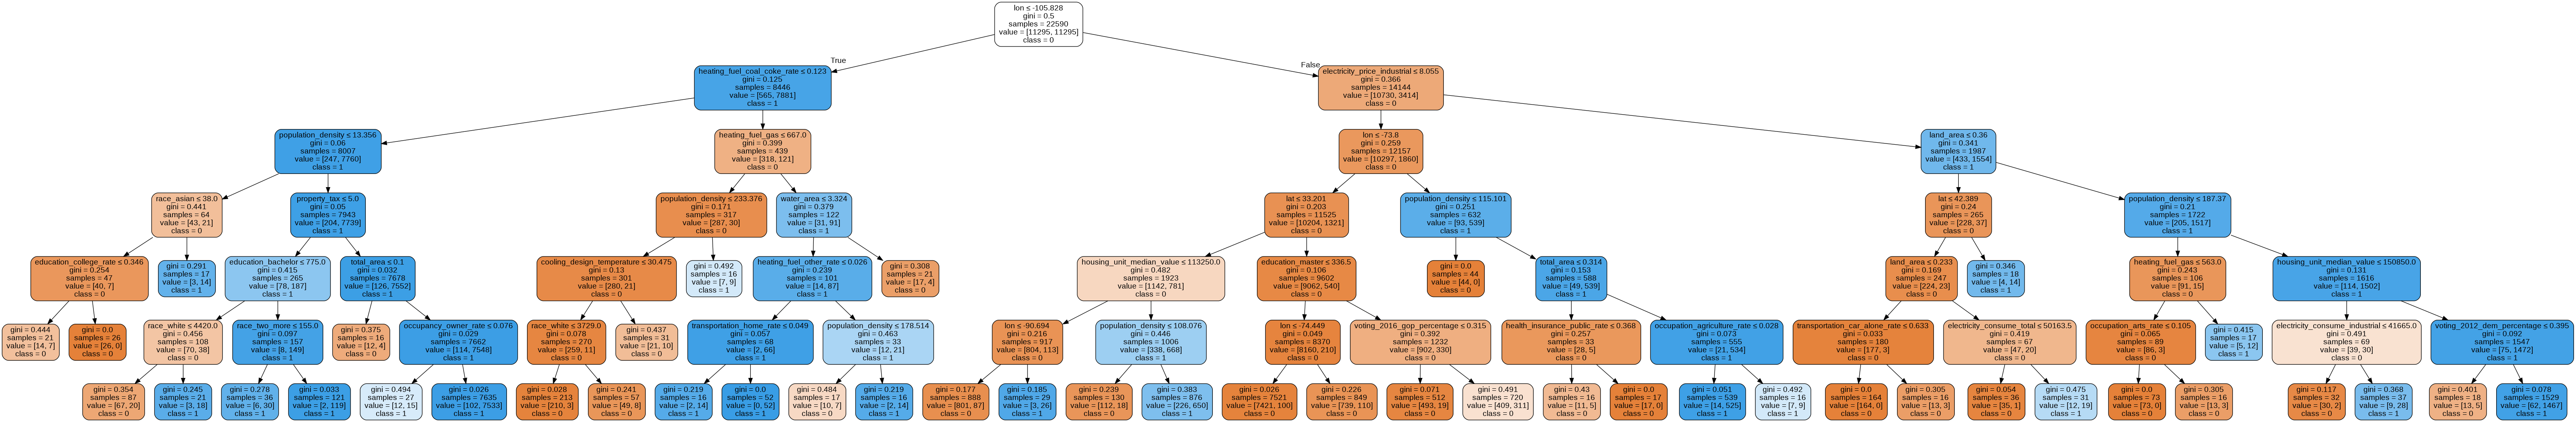

In [ ]:
show_tree(cart,X.columns,'tree.png')

In [ ]:
!pip install scikit-plot

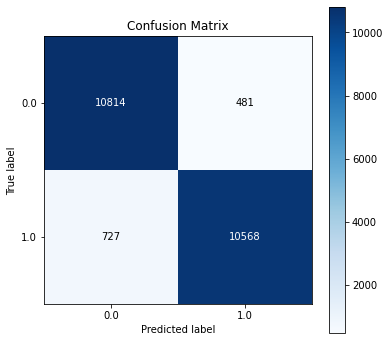

In [ ]:
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc
plot_confusion_matrix(Y, 
                      y_cart_predict,
                      figsize=(6,6),
                      title="Confusion Matrix")

In [ ]:
data = classification_report(Y, y_cart_predict)
print(data)

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     11295
         1.0       0.96      0.94      0.95     11295

    accuracy                           0.95     22590
   macro avg       0.95      0.95      0.95     22590
weighted avg       0.95      0.95      0.95     22590

